In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
import seaborn
%matplotlib inline

### 数据获取

In [2]:
hf = ts.get_k_data('600893', '2000-01-01', '2018-07-31')
hf.set_index('date',inplace = True)
hf.index = pd.to_datetime(hf.index)    #因为要merge操作，要把date转换成日期格式；
hf.head()

,open,close,high,low,volume,code
date,,,,,,
2000-01-04,2.960,3.003,3.017,2.921,2325.06,600893
2000-01-05,3.008,3.003,3.046,2.969,4901.63,600893
2000-01-06,2.974,3.084,3.089,2.969,4637.20,600893
2000-01-07,3.065,3.190,3.199,3.065,11379.67,600893
2000-01-10,3.209,3.199,3.242,3.113,12627.31,600893


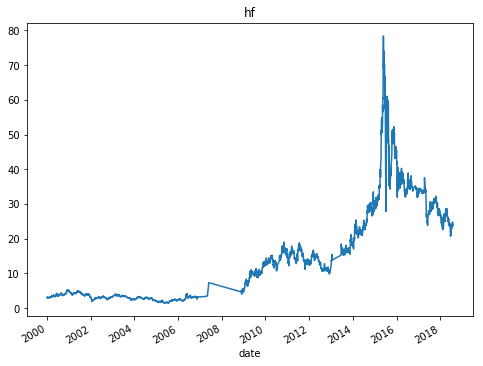

In [4]:
hf_close = hf['close']
hf.close.plot(figsize = (8,6),title = 'hf')

### 特征值处理

In [5]:
for i in range(1, 21, 1):
    hf['close - ' + str(i) + 'd'] = hf['close'].shift(i)
hf_20d = hf[[x for x in hf.columns if 'close' in x]].iloc[20:]
hf_20d = hf_20d.iloc[:,::-1]                #转换特征的顺序；
hf_20d.head()

,close - 20d,close - 19d,close - 18d,close - 17d,close - 16d,close - 15d,close - 14d,close - 13d,close - 12d,close - 11d,...,close - 9d,close - 8d,close - 7d,close - 6d,close - 5d,close - 4d,close - 3d,close - 2d,close - 1d,close
date,,,,,,,,,,,,,,,,,,,,,
2000-02-15,3.003,3.003,3.084,3.190,3.199,3.046,2.988,2.979,3.012,2.984,...,2.955,3.003,2.964,2.921,2.950,2.936,2.907,2.950,3.223,3.060
2000-02-16,3.003,3.084,3.190,3.199,3.046,2.988,2.979,3.012,2.984,2.931,...,3.003,2.964,2.921,2.950,2.936,2.907,2.950,3.223,3.060,3.041
2000-02-17,3.084,3.190,3.199,3.046,2.988,2.979,3.012,2.984,2.931,2.955,...,2.964,2.921,2.950,2.936,2.907,2.950,3.223,3.060,3.041,3.103
2000-02-18,3.190,3.199,3.046,2.988,2.979,3.012,2.984,2.931,2.955,3.003,...,2.921,2.950,2.936,2.907,2.950,3.223,3.060,3.041,3.103,3.012
2000-02-21,3.199,3.046,2.988,2.979,3.012,2.984,2.931,2.955,3.003,2.964,...,2.950,2.936,2.907,2.950,3.223,3.060,3.041,3.103,3.012,3.127


### 生成训练集和测试集

In [6]:
features_train = hf_20d[:2700]
labels_train = hf_20d['close'].shift(-1)[:2700]     

features_test = hf_20d[2700:]
labels_test = hf_20d['close'].shift(-1)[2700:]

### 训练模型

In [8]:
from sklearn import svm

clf = svm.SVR(kernel='linear')
clf.fit(features_train, labels_train)     #模型的训练过程；

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [11]:
predict = clf.predict(features_test)      #返回测试集的标签

df = pd.DataFrame(labels_test)            #测试集真实股价

df['predict'] = predict                   #预测测试集的股价给添加到DataFrame中

df = df.rename(columns = {'close': 'Next Close', 'predict':'Predict Next Close'})
df.head()

,Next Close,Predict Next Close
date,,
2013-10-15,16.573,16.806762
2013-10-16,16.387,16.550011
2013-10-17,16.661,16.382021
2013-10-18,16.994,16.721669
2013-10-21,17.395,17.000866


In [12]:
current_close = hf_20d[['close']].iloc[2700:]

next_open = hf[['open']].iloc[2720:].shift(-1)    #把8月3号的开盘价放到了8月2号的位置；

df1 = pd.merge(df, current_close, left_index=True, right_index=True)

df2 = pd.merge(df1, next_open, left_index=True, right_index=True)

df2.columns = ['Next Close', 'Predicted Next Close', 'Current Close', 'Next Open']

df2.head()

,Next Close,Predicted Next Close,Current Close,Next Open
date,,,,
2013-10-15,16.573,16.806762,16.837,16.778
2013-10-16,16.387,16.550011,16.573,16.798
2013-10-17,16.661,16.382021,16.387,16.436
2013-10-18,16.994,16.721669,16.661,16.778
2013-10-21,17.395,17.000866,16.994,17.033


### 开仓信号挖掘

In [17]:
df2['Signal'] = np.where(df2['Predicted Next Close'] > df2['Next Open'] ,1,0)
df2['PL'] =  np.where(df2['Signal'] == 1,(df2['Next Close'] - df2['Next Open'])/df2['Next Open'],0)
df2.head()

,Next Close,Predicted Next Close,Current Close,Next Open,Signal,PL
date,,,,,,
2013-10-15,16.573,16.806762,16.837,16.778,1,-0.012218
2013-10-16,16.387,16.550011,16.573,16.798,0,0.000000
2013-10-17,16.661,16.382021,16.387,16.436,0,0.000000
2013-10-18,16.994,16.721669,16.661,16.778,0,0.000000
2013-10-21,17.395,17.000866,16.994,17.033,0,0.000000


### 收益及可视化

In [18]:
df2['Strategy'] = (df2['PL'].shift(1)+1).cumprod()
df2['return'] = (df2['Next Close'].pct_change()+1).cumprod()
df2.head()

,Next Close,Predicted Next Close,Current Close,Next Open,Signal,PL,Strategy,return
date,,,,,,,,
2013-10-15,16.573,16.806762,16.837,16.778,1,-0.012218,NaN,NaN
2013-10-16,16.387,16.550011,16.573,16.798,0,0.000000,0.987782,0.988777
2013-10-17,16.661,16.382021,16.387,16.436,0,0.000000,0.987782,1.005310
2013-10-18,16.994,16.721669,16.661,16.778,0,0.000000,0.987782,1.025403
2013-10-21,17.395,17.000866,16.994,17.033,0,0.000000,0.987782,1.049599


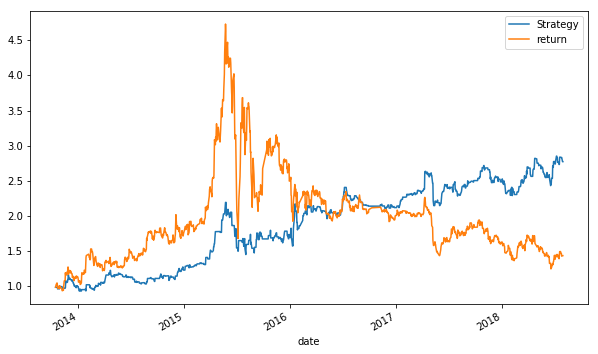

In [19]:
df2[['Strategy','return']].dropna().plot(figsize=(10, 6))